# EDA :

In [5]:
import pandas as pd
import math
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df_raw = pd.read_csv('dpi_fraud_flag_cgi.csv')

In [7]:
df_raw.columns.tolist()

['msisdn',
 'event_date',
 'cgi',
 'rat',
 'profile_name',
 'quota_name',
 'protocol',
 'domain',
 'ip_destination',
 'accessed_category',
 'accessed_app',
 'kpi_data_volume_total_bytes',
 'total_volume_bcp',
 'hits_tether',
 'rxmit_packets_in',
 'rxmit_packets_out',
 'packets_in',
 'packets_out',
 'bucket_usage',
 'flag']

In [8]:
df_raw.accessed_category.value_counts()

Communications      21613
Attack               8662
GoogleServices       3254
Music                1363
Web                   925
unclassified          643
VPN                   579
Games                 500
ApplicationStore      299
Proxy                 251
CDN                   213
Images                166
Education             138
Backup                119
Mail                  107
CloudServices          77
Technology             73
Net                    70
Finance                64
P2P                    56
CloudStorage           56
Ads                    53
non-established        52
DeviceServices         48
Remote                 47
Update                 43
FileSharing            28
Lifestyle              27
News                   21
Media                  15
Productivity           14
AppleServices           9
Enterprise              9
WebApps                 9
Telco                   7
eCommerce               3
Sports                  2
Automotive              1
Name: access

<AxesSubplot:xlabel='flag', ylabel='count'>

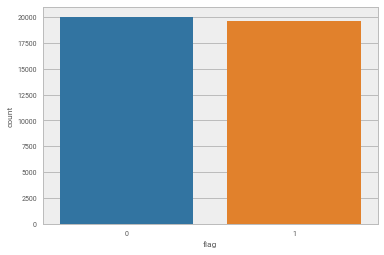

In [9]:
sns.countplot(x='flag', data=df_raw)

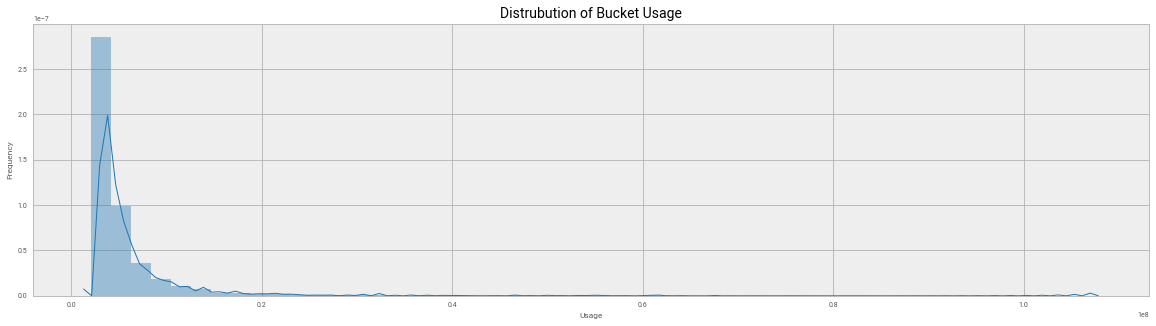

In [10]:
plt.subplots(figsize=(20,5))
sns.distplot(df_raw.bucket_usage)
plt.title('Distrubution of Bucket Usage',fontsize= 14)
plt.xlabel('Usage')
plt.ylabel('Frequency')
plt.show()

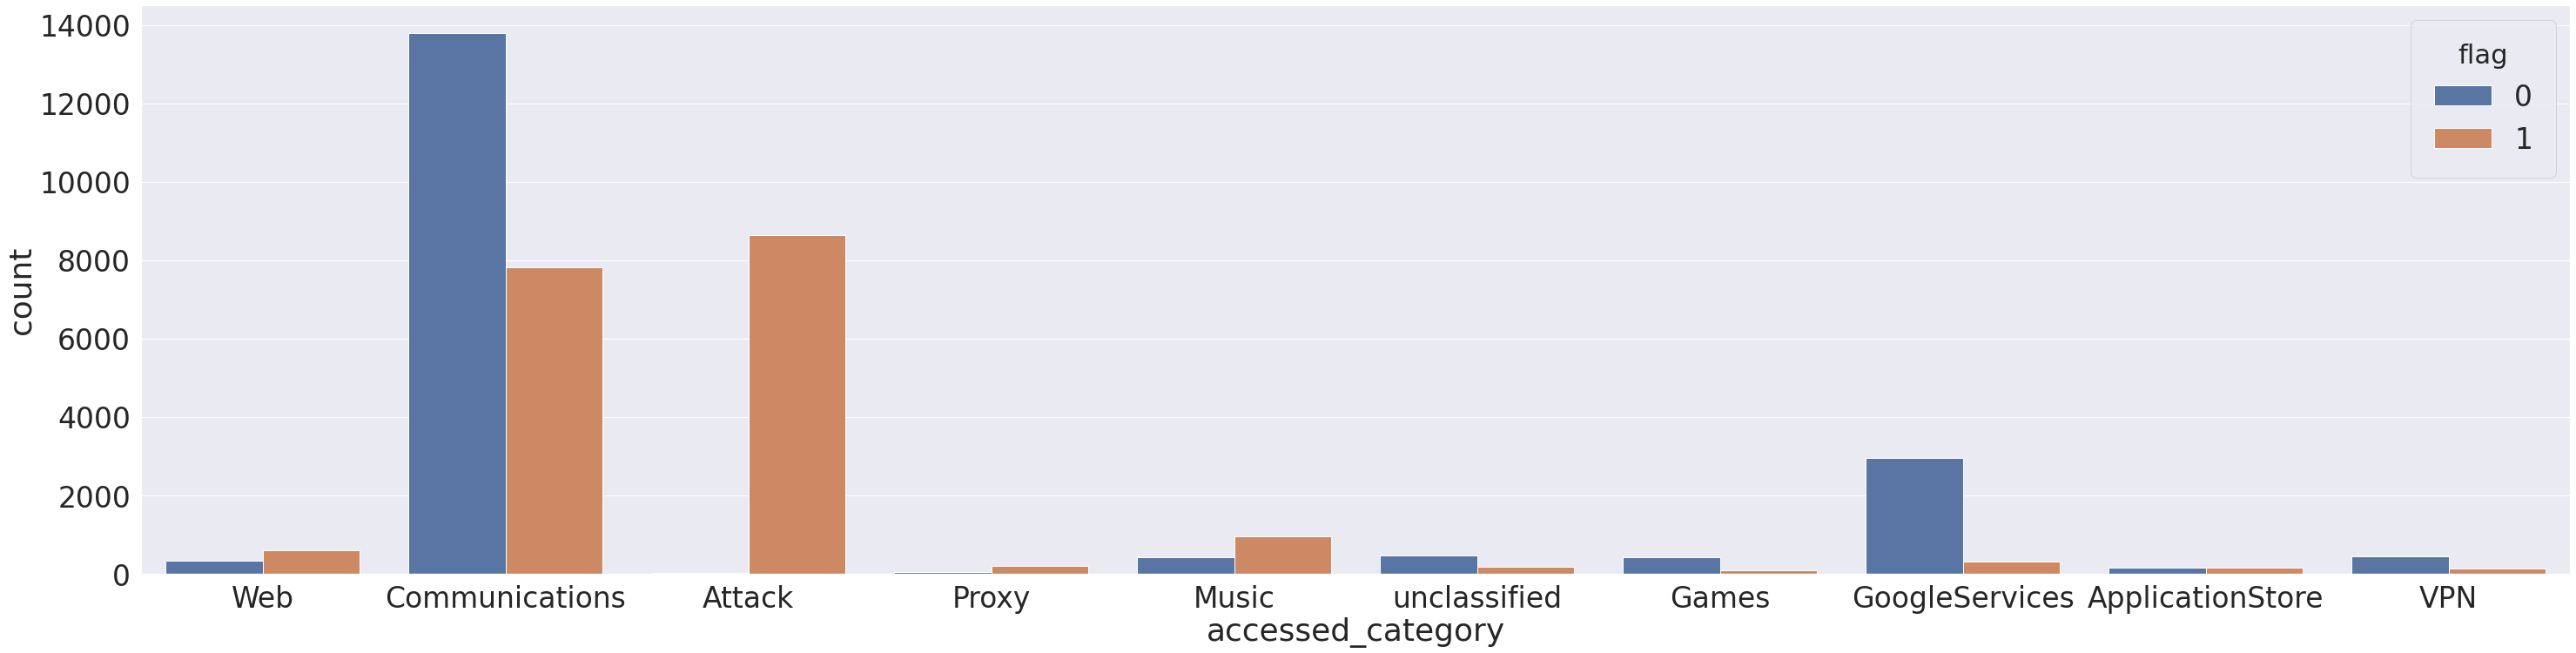

In [11]:
sns.set(font_scale = 3)
plt.subplots(figsize = (50,12))
sns.countplot('accessed_category',hue='flag',data=df_raw[df_raw['accessed_category'].isin(['Communications','Attack',
 'GoogleServices', 'Music','Web', 'unclassified', 'VPN', 'Games','ApplicationStore', 'Proxy'])])

plt.show()

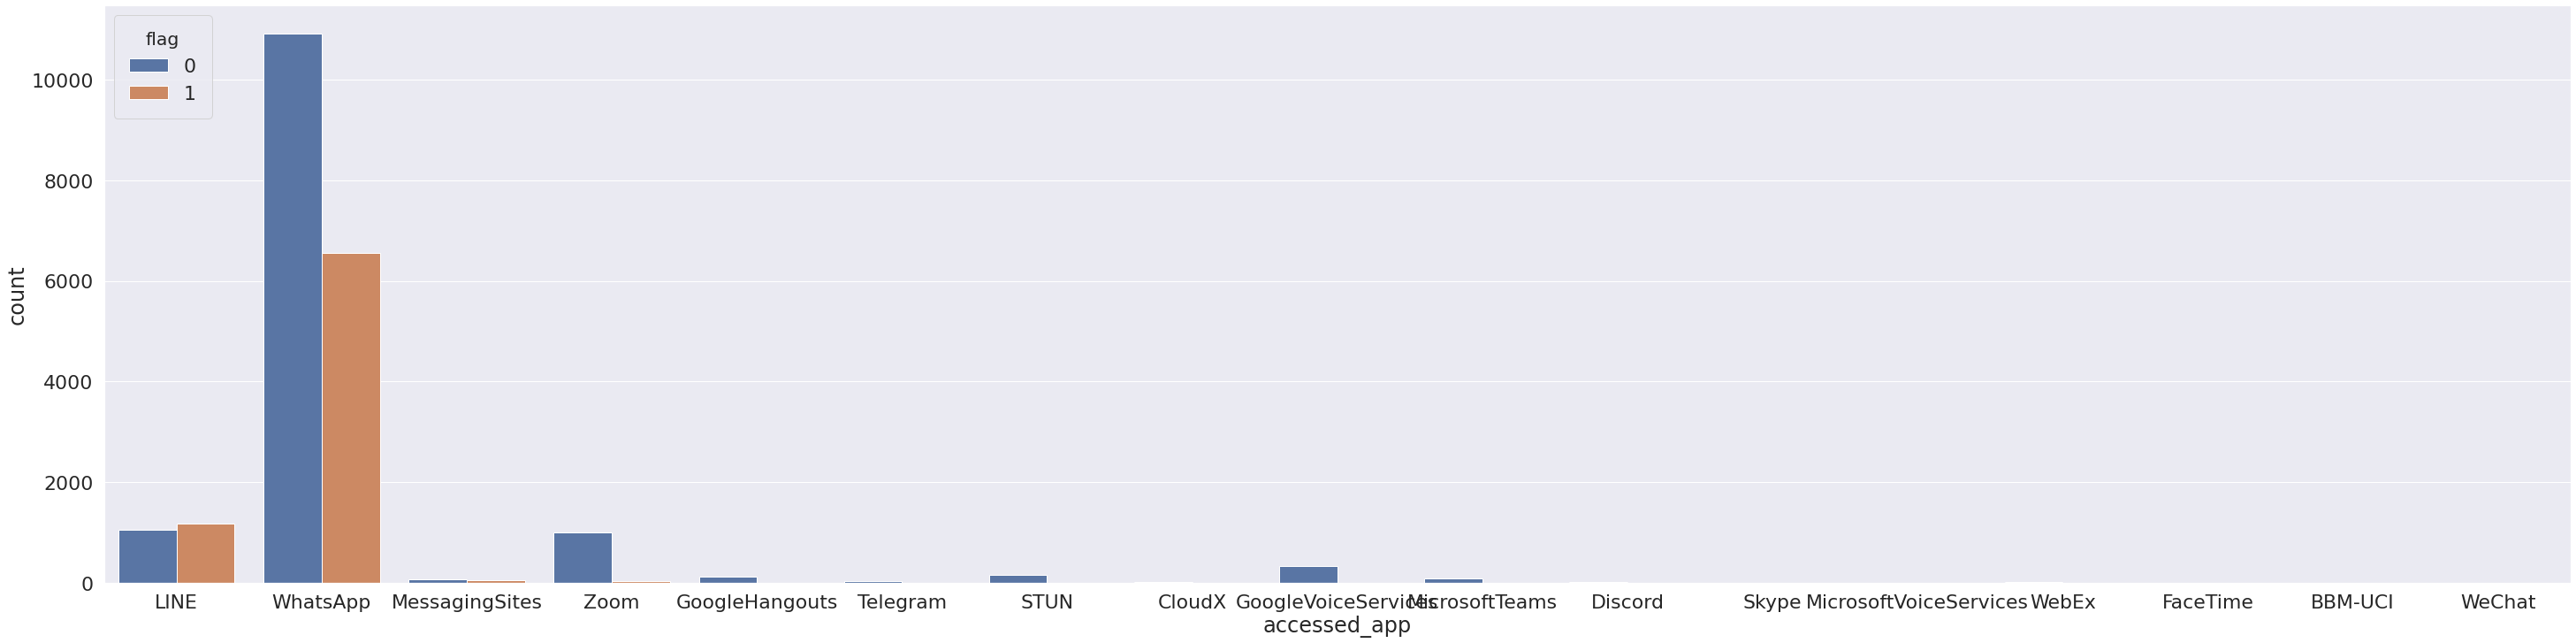

In [12]:
sns.set(font_scale = 2)
plt.subplots(figsize = (50,12))
sns.countplot('accessed_app',hue='flag',data=df_raw[df_raw['accessed_category'].isin(['Communications'])])

plt.show()

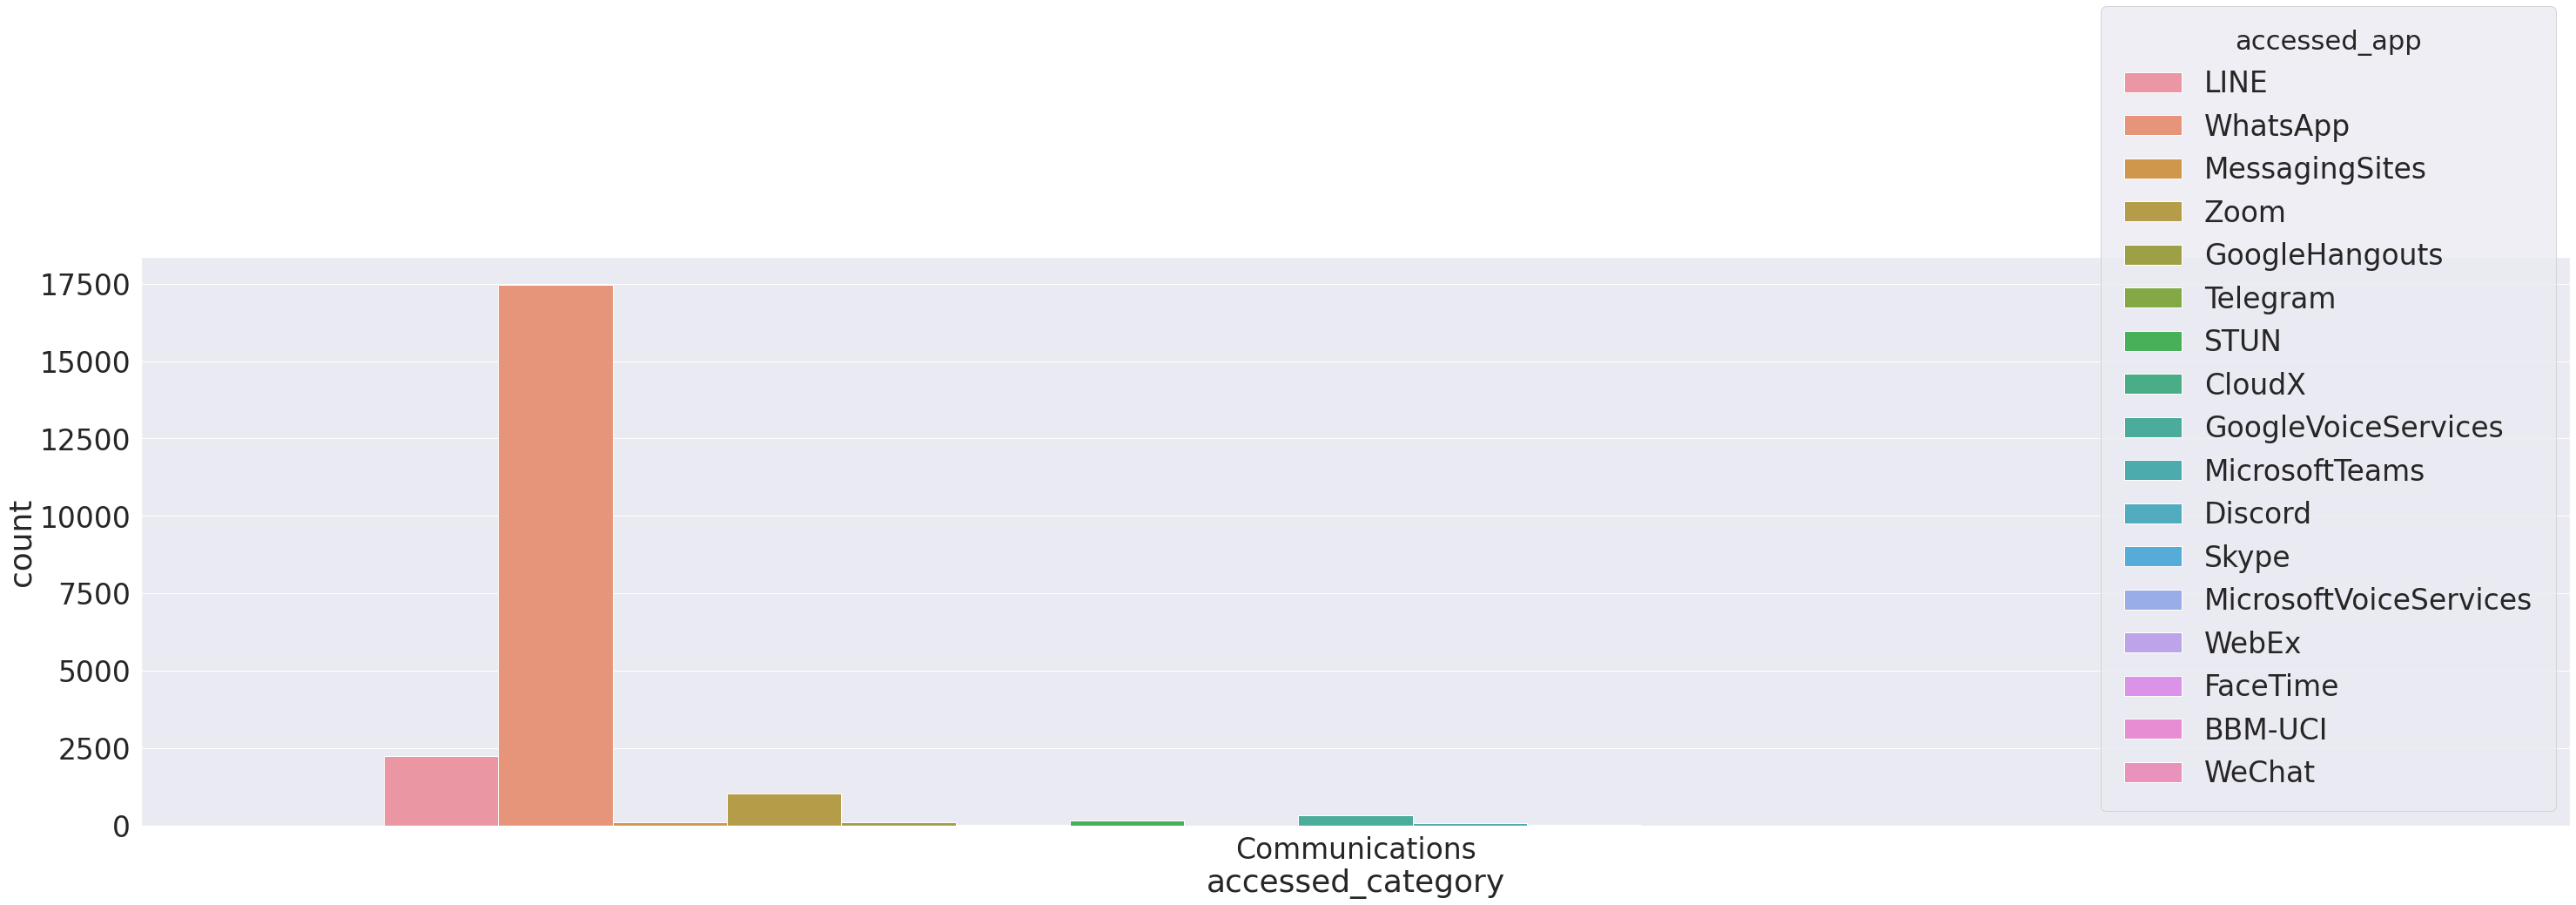

In [13]:
sns.set(font_scale = 3)
plt.subplots(figsize = (50,12))
sns.countplot('accessed_category',hue='accessed_app',data=df_raw[df_raw['accessed_category'].isin(['Communications'])])

plt.show()

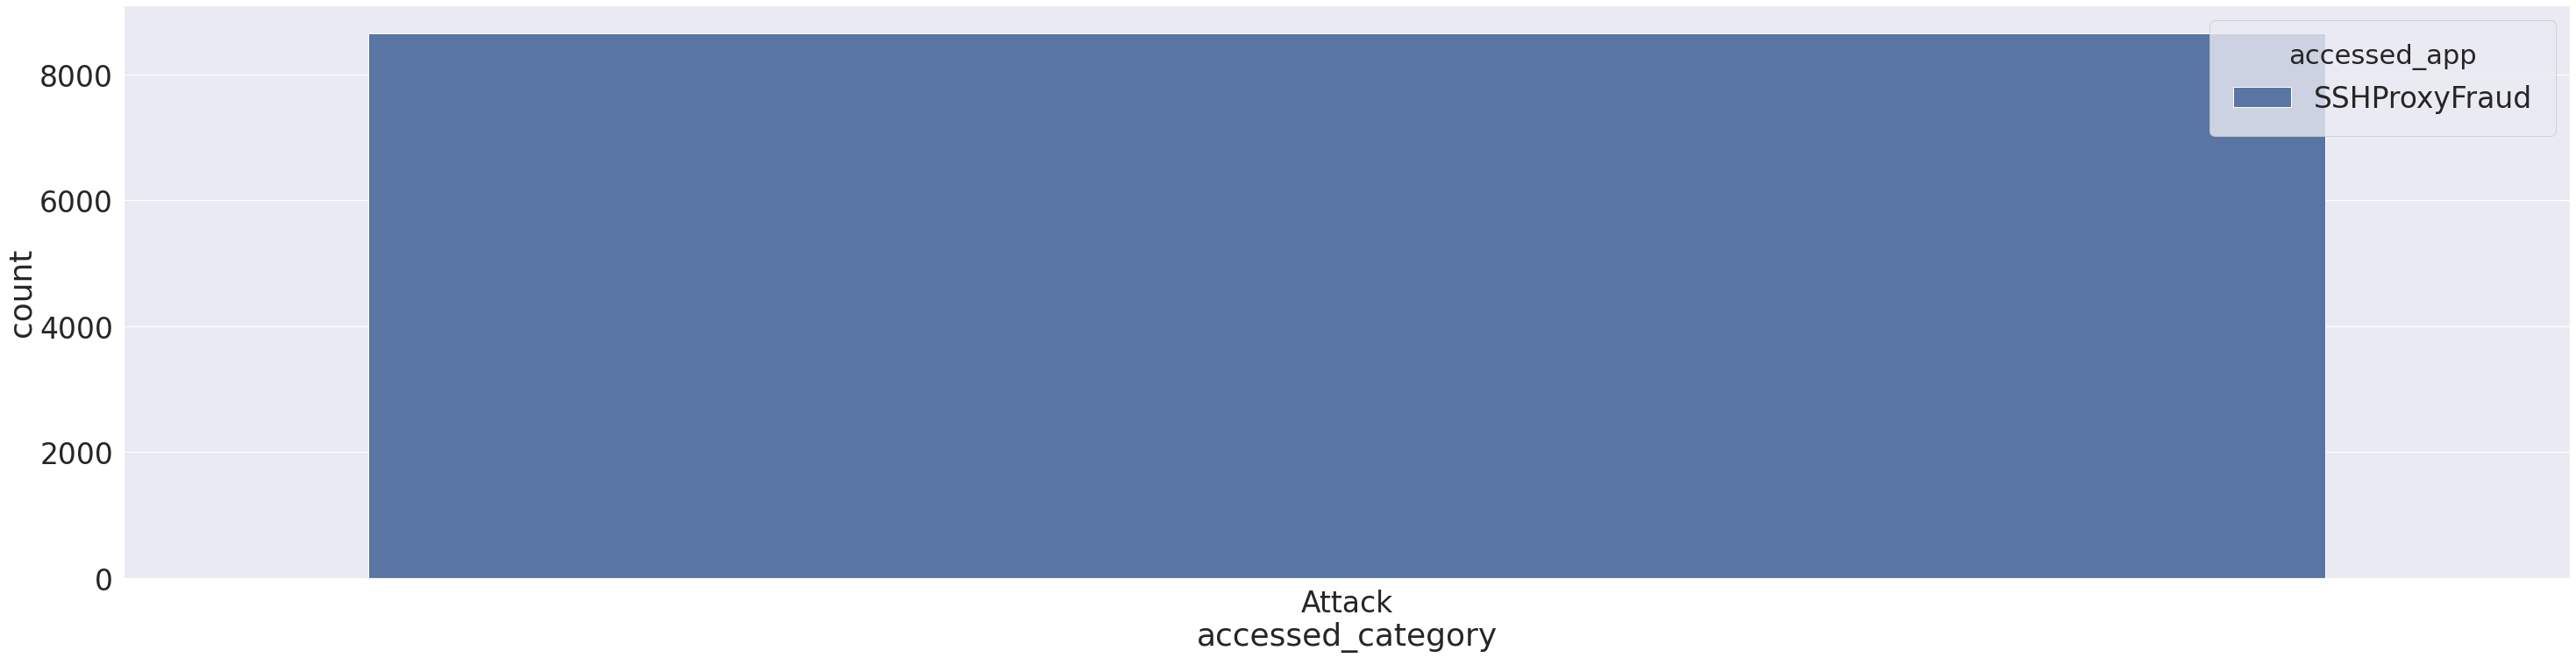

In [14]:
sns.set(font_scale = 3)
plt.subplots(figsize = (50,12))
sns.countplot('accessed_category',hue='accessed_app',data=df_raw[df_raw['accessed_category'].isin(['Attack'])])

plt.show()

# Data Handling :

In [15]:
df_raw['total_packets'] = df_raw['packets_in']+df_raw['packets_out']
df_raw['total_rxmit'] = df_raw['rxmit_packets_in']+df_raw['rxmit_packets_out']

In [16]:
to_flag_cols = ['bucket_usage', 'total_volume_bcp', 'total_rxmit', 'total_packets']
flag_cols = ['bucket_usage_labels', 'total_volume_bcp_labels', 'total_rxmit_labels', 'total_packets_labels']
for col in to_flag_cols:
    df_raw[col + '_labels'] = (df_raw[col] > df_raw[col].median())
    df_raw[col + '_labels'] = df_raw[col + '_labels'].astype(int) #convert from boolean to integer
df_raw
for col in flag_cols:
    print(col + ' 0 count:', df_raw[col].count()-df_raw[col].sum())
    print(col + ' 1 count:', df_raw[col].sum())

bucket_usage_labels 0 count: 19808
bucket_usage_labels 1 count: 19808
total_volume_bcp_labels 0 count: 19808
total_volume_bcp_labels 1 count: 19808
total_rxmit_labels 0 count: 19809
total_rxmit_labels 1 count: 19807
total_packets_labels 0 count: 19808
total_packets_labels 1 count: 19808


In [17]:
df_raw['event_date']  = pd.to_datetime(df_raw.event_date.astype(str), format='%Y-%m-%d')

df_join = df_raw.copy()
for col in to_flag_cols:
    df_tes = df_join.copy()
    df_tes = df_tes[['msisdn', 'event_date',col +'_labels']]
    df_tes = df_tes.groupby(['msisdn', 'event_date']).max().reset_index()
    
    dummy_date =  df_tes[['event_date']].min() - timedelta(days=7)
    df_date = df_tes[['event_date']].drop_duplicates()
    df_date.iloc[-1]= dummy_date
    df_date.index = df_date.index+1
    dates = df_date.set_index('event_date').resample('D').asfreq().index
    
    msisdn = df_tes['msisdn'].unique()
    
    idx = pd.MultiIndex.from_product((dates, msisdn), names=['event_date', 'msisdn'])
    
    df_tes = df_tes.set_index(['event_date', 'msisdn']).reindex(idx).reset_index().sort_values(by=['event_date', 'msisdn'], ascending=True).reset_index(level=0, drop=True).fillna(0)
    df_tes[col +'_count'] = df_tes.groupby(['msisdn'])[col +'_labels'].rolling(7).sum().reset_index(level=0, drop=True)
    df_tes = df_tes.drop([col +'_labels'],1)
    
    df_join = pd.merge(df_join, df_tes,  how='left', left_on=['msisdn','event_date'], right_on = ['msisdn','event_date'])


In [18]:
df_join.head(5)

,msisdn,event_date,cgi,rat,profile_name,quota_name,protocol,domain,ip_destination,accessed_category,accessed_app,kpi_data_volume_total_bytes,total_volume_bcp,hits_tether,rxmit_packets_in,rxmit_packets_out,packets_in,packets_out,bucket_usage,flag,total_packets,total_rxmit,bucket_usage_labels,total_volume_bcp_labels,total_rxmit_labels,total_packets_labels,bucket_usage_count,total_volume_bcp_count,total_rxmit_count,total_packets_count
0,6281210077714,2020-12-01,510100148743021,4G,ULDPI_B2C_Redflag1_Std,Q_ULDPI_B2C_Redflag1_Std,HTTP,http://line.me,51.79.146.228,Web,HTTP,185214163.0,3633776001,0,430,942,2348290,1665496,3516935,1,4013786,1372,0,1,0,1,1.0,1.0,1.0,1.0
1,6281210077714,2020-12-01,510100148743022,4G,ULDPI_B2C_Redflag1_Std,Q_ULDPI_B2C_Redflag1_Std,HTTP,http://line.me,51.79.146.228,Web,HTTP,185214163.0,7242484799,0,3148,3555,4649069,3960297,6907476,1,8609366,6703,1,1,1,1,1.0,1.0,1.0,1.0
2,6281210077714,2020-12-03,510100148743021,4G,ULDPI_B2C_Redflag1_Std,Q_ULDPI_B2C_Redflag1_Std,HTTP,http://line.me,103.65.237.39,Web,HTTP,13034645.0,3185885366,0,1895,1323,2509610,835718,3072001,1,3345328,3218,0,0,0,1,3.0,3.0,3.0,3.0
3,6281210077714,2020-12-03,510100148743025,4G,ULDPI_B2C_Redflag1_Std,Q_ULDPI_B2C_Redflag1_Std,HTTP,http://line.me,103.65.237.39,Web,HTTP,13034645.0,9893298731,0,4578,3600,7250319,3455702,10827474,1,10706021,8178,1,1,1,1,3.0,3.0,3.0,3.0
4,6281210077714,2020-12-03,510100148743021,4G,ULDPI_B2C_Redflag1_Std,Q_ULDPI_B2C_Redflag1_Std,HTTP,http://line.me,111.221.45.20,Web,HTTP,5464380.0,3185885366,0,1895,1323,2509610,835718,3072001,1,3345328,3218,0,0,0,1,3.0,3.0,3.0,3.0


In [19]:
(df_join.corr()*100)['flag']

msisdn                          19.097403
cgi                              9.215979
kpi_data_volume_total_bytes           NaN
total_volume_bcp                15.086714
hits_tether                    -10.785175
rxmit_packets_in                 5.757597
rxmit_packets_out                3.465614
packets_in                      14.766005
packets_out                      7.221634
bucket_usage                    18.377777
flag                           100.000000
total_packets                   12.766260
total_rxmit                      5.907435
bucket_usage_labels             20.103933
total_volume_bcp_labels         15.852926
total_rxmit_labels               8.688768
total_packets_labels             8.976593
bucket_usage_count              22.126054
total_volume_bcp_count          20.281798
total_rxmit_count                9.422494
total_packets_count             16.954270
Name: flag, dtype: float64

In [20]:
df_raw = df_join.drop(['kpi_data_volume_total_bytes','accessed_app','domain','ip_destination','quota_name','profile_name','rat','protocol'], axis=1)

In [21]:
for col in to_flag_cols:
    df_raw[col + '_labels'] = (df_raw[col] > df_raw[col].median())
    df_raw[col + '_labels'] = df_raw[col + '_labels'].astype(int) #convert from boolean to integer
df_raw.head(3)

,msisdn,event_date,cgi,accessed_category,total_volume_bcp,hits_tether,rxmit_packets_in,rxmit_packets_out,packets_in,packets_out,bucket_usage,flag,total_packets,total_rxmit,bucket_usage_labels,total_volume_bcp_labels,total_rxmit_labels,total_packets_labels,bucket_usage_count,total_volume_bcp_count,total_rxmit_count,total_packets_count
0,6281210077714,2020-12-01,510100148743021,Web,3633776001,0,430,942,2348290,1665496,3516935,1,4013786,1372,0,1,0,1,1.0,1.0,1.0,1.0
1,6281210077714,2020-12-01,510100148743022,Web,7242484799,0,3148,3555,4649069,3960297,6907476,1,8609366,6703,1,1,1,1,1.0,1.0,1.0,1.0
2,6281210077714,2020-12-03,510100148743021,Web,3185885366,0,1895,1323,2509610,835718,3072001,1,3345328,3218,0,0,0,1,3.0,3.0,3.0,3.0


In [22]:
df_raw['bucket_usage_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['bucket_usage_labels'].transform('sum')
df_raw['total_volume_bcp_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['total_volume_bcp_labels'].transform('sum')
df_raw['total_rxmit_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['total_rxmit_labels'].transform('sum')
df_raw['total_packets_count'] =df_raw.groupby(['msisdn', 'accessed_category', 'event_date'])['total_packets_labels'].transform('sum')

# One Hot Encoding for Categorical Features :

In [23]:
one_hot = pd.get_dummies(df_raw['accessed_category'])

df_raw = df_raw.drop('accessed_category',axis = 1)
df_raw = df_raw.join(one_hot)
df_raw

,msisdn,event_date,cgi,total_volume_bcp,hits_tether,rxmit_packets_in,rxmit_packets_out,packets_in,packets_out,bucket_usage,flag,total_packets,total_rxmit,bucket_usage_labels,total_volume_bcp_labels,total_rxmit_labels,total_packets_labels,bucket_usage_count,total_volume_bcp_count,total_rxmit_count,total_packets_count,Ads,AppleServices,ApplicationStore,Attack,Automotive,Backup,CDN,CloudServices,CloudStorage,Communications,DeviceServices,Education,Enterprise,FileSharing,Finance,Games,GoogleServices,Images,Lifestyle,Mail,Media,Music,Net,News,P2P,Productivity,Proxy,Remote,Sports,Technology,Telco,Update,VPN,Web,WebApps,eCommerce,non-established,unclassified
0,6281210077714,2020-12-01,510100148743021,3633776001,0,430,942,2348290,1665496,3516935,1,4013786,1372,0,1,0,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,6281210077714,2020-12-01,510100148743022,7242484799,0,3148,3555,4649069,3960297,6907476,1,8609366,6703,1,1,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,6281210077714,2020-12-03,510100148743021,3185885366,0,1895,1323,2509610,835718,3072001,1,3345328,3218,0,0,0,1,8,8,8,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,6281210077714,2020-12-03,510100148743025,9893298731,0,4578,3600,7250319,3455702,10827474,1,10706021,8178,1,1,1,1,8,8,8,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,6281210077714,2020-12-03,510100148743021,3185885366,0,1895,1323,2509610,835718,3072001,1,3345328,3218,0,0,0,1,8,8,8,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39611,6281218494370,2020-12-27,510100115092031,2580432282,7,2101,384,1859937,516418,4718256,0,2376355,2485,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39612,6281218494370,2020-12-29,510100115092031,2355155833,4,1356,549,1683932,488460,5793288,0,2172392,1905,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39613,6281218494370,2020-12-30,510100115092031,2379550251,8,1956,415,1707649,452282,5863239,0,2159931,2371,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39614,6281218494764,2020-12-02,510100145613034,2626314338,0,546,852,1866256,758556,2520314,0,2624812,1398,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df_raw.isnull().sum()

msisdn                     0
event_date                 0
cgi                        0
total_volume_bcp           0
hits_tether                0
rxmit_packets_in           0
rxmit_packets_out          0
packets_in                 0
packets_out                0
bucket_usage               0
flag                       0
total_packets              0
total_rxmit                0
bucket_usage_labels        0
total_volume_bcp_labels    0
total_rxmit_labels         0
total_packets_labels       0
bucket_usage_count         0
total_volume_bcp_count     0
total_rxmit_count          0
total_packets_count        0
Ads                        0
AppleServices              0
ApplicationStore           0
Attack                     0
Automotive                 0
Backup                     0
CDN                        0
CloudServices              0
CloudStorage               0
Communications             0
DeviceServices             0
Education                  0
Enterprise                 0
FileSharing   

# Learning

In [25]:
df_tes = df_raw.copy()
df_learn = df_tes.copy()

In [26]:
df_learn.columns

Index(['msisdn', 'event_date', 'cgi', 'total_volume_bcp', 'hits_tether',
       'rxmit_packets_in', 'rxmit_packets_out', 'packets_in', 'packets_out',
       'bucket_usage', 'flag', 'total_packets', 'total_rxmit',
       'bucket_usage_labels', 'total_volume_bcp_labels', 'total_rxmit_labels',
       'total_packets_labels', 'bucket_usage_count', 'total_volume_bcp_count',
       'total_rxmit_count', 'total_packets_count', 'Ads', 'AppleServices',
       'ApplicationStore', 'Attack', 'Automotive', 'Backup', 'CDN',
       'CloudServices', 'CloudStorage', 'Communications', 'DeviceServices',
       'Education', 'Enterprise', 'FileSharing', 'Finance', 'Games',
       'GoogleServices', 'Images', 'Lifestyle', 'Mail', 'Media', 'Music',
       'Net', 'News', 'P2P', 'Productivity', 'Proxy', 'Remote', 'Sports',
       'Technology', 'Telco', 'Update', 'VPN', 'Web', 'WebApps', 'eCommerce',
       'non-established', 'unclassified'],
      dtype='object')

In [27]:
(df_learn.corr()*100)['flag']

msisdn                      19.097403
cgi                          9.215979
total_volume_bcp            15.086714
hits_tether                -10.785175
rxmit_packets_in             5.757597
rxmit_packets_out            3.465614
packets_in                  14.766005
packets_out                  7.221634
bucket_usage                18.377777
flag                       100.000000
total_packets               12.766260
total_rxmit                  5.907435
bucket_usage_labels         20.103933
total_volume_bcp_labels     15.852926
total_rxmit_labels           8.688768
total_packets_labels         8.976593
bucket_usage_count          26.263341
total_volume_bcp_count      24.461157
total_rxmit_count           26.334949
total_packets_count         23.658493
Ads                         -2.934178
AppleServices               -1.492882
ApplicationStore             0.580375
Attack                      53.207010
Automotive                  -0.497577
Backup                      -5.436028
CDN         

In [28]:
df_learn = df_learn.drop(['rxmit_packets_in','rxmit_packets_out','packets_out','total_rxmit','total_rxmit_labels','total_packets_labels','bucket_usage_labels'], axis=1)

In [29]:
input_cols = ['total_volume_bcp', 'hits_tether',
       'packets_in', 'bucket_usage', 'total_packets',
       'total_volume_bcp_labels', 'bucket_usage_count',
       'total_volume_bcp_count', 'total_rxmit_count', 'total_packets_count', 'ApplicationStore', 'Attack',
       'Backup', 'CDN', 'Communications',
       'Games', 'GoogleServices',
       'Music', 'Proxy', 'Update', 'VPN', 'Web', 'WebApps',
       'eCommerce', 'non-established', 'unclassified']
        
output_cols = 'flag'
df_learn = df_learn[input_cols + [output_cols,] ].dropna()
df_learn

,total_volume_bcp,hits_tether,packets_in,bucket_usage,total_packets,total_volume_bcp_labels,bucket_usage_count,total_volume_bcp_count,total_rxmit_count,total_packets_count,ApplicationStore,Attack,Backup,CDN,Communications,Games,GoogleServices,Music,Proxy,Update,VPN,Web,WebApps,eCommerce,non-established,unclassified,flag
0,3633776001,0,2348290,3516935,4013786,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,7242484799,0,4649069,6907476,8609366,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,3185885366,0,2509610,3072001,3345328,0,8,8,8,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,9893298731,0,7250319,10827474,10706021,1,8,8,8,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,3185885366,0,2509610,3072001,3345328,0,8,8,8,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39611,2580432282,7,1859937,4718256,2376355,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
39612,2355155833,4,1683932,5793288,2172392,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
39613,2379550251,8,1707649,5863239,2159931,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
39614,2626314338,0,1866256,2520314,2624812,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
X = df_learn.drop(output_cols, axis=1)
y = df_learn[output_cols]

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(len(X_train), len(X_test))

31692 7924


# RF Classifier :

In [32]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
y_pred = rfc.predict(X_test)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3912  176]
 [ 635 3201]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4088
           1       0.95      0.83      0.89      3836

    accuracy                           0.90      7924
   macro avg       0.90      0.90      0.90      7924
weighted avg       0.90      0.90      0.90      7924



# Feature Importance :

In [35]:
for i,j in enumerate(rfc.feature_importances_):
    print(df_learn.columns[i],'\t\t', j*100)

total_volume_bcp 		 8.775378825484978
hits_tether 		 1.622674712290605
packets_in 		 8.982481241685978
bucket_usage 		 9.014109160894161
total_packets 		 8.806820158745312
total_volume_bcp_labels 		 0.2945651732541978
bucket_usage_count 		 13.85821668352412
total_volume_bcp_count 		 7.227756370344046
total_rxmit_count 		 11.038184197199694
total_packets_count 		 7.349800850703046
ApplicationStore 		 0.10453871530085518
Attack 		 16.192644474154637
Backup 		 0.08425460315162481
CDN 		 0.07161191121886072
Communications 		 1.9629988971753547
Games 		 0.28429010525231085
GoogleServices 		 2.190183786791207
Music 		 0.7977228629529572
Proxy 		 0.39801884795388276
Update 		 0.020311071226924472
VPN 		 0.27092970166042357
Web 		 0.36316162534561724
WebApps 		 0.00043571823908841284
eCommerce 		 0.0012374399970784995
non-established 		 0.1118085198749014
unclassified 		 0.17586434557813296


In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [37]:
cross_val = KFold(n_splits=3, random_state=42)
scores = cross_val_score(rfc, X_test, y_test, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Decision Tree: ", scores.mean())

Mean AUC Score - Decision Tree:  0.9322059453737906


# SHAP :

In [47]:
import shap

In [ ]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)

# Pickling :

In [38]:
import pickle

In [39]:
Pkl_Filename = "Picke_RFC_v1.pkl"
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rfc, file)

In [41]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_rfc = pickle.load(file)

Pickled_rfc

RandomForestClassifier()

In [43]:
# Use the Reloaded Model to 
# Calculate the accuracy score and predict target values

# Calculate the Score 
score = Pickled_rfc.score(X_test, y_test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_rfc.predict(X_test)  

Ypredict

Test score: 90.37 %


array([0, 1, 0, ..., 0, 0, 0])

# PyCaret :

In [38]:
from pycaret.classification import *

In [39]:
df_tes.columns

Index(['msisdn', 'event_date', 'cgi', 'total_volume_bcp', 'hits_tether',
       'rxmit_packets_in', 'rxmit_packets_out', 'packets_in', 'packets_out',
       'bucket_usage', 'flag', 'total_packets', 'total_rxmit',
       'bucket_usage_labels', 'total_volume_bcp_labels', 'total_rxmit_labels',
       'total_packets_labels', 'bucket_usage_count', 'total_volume_bcp_count',
       'total_rxmit_count', 'total_packets_count', 'Ads', 'AppleServices',
       'ApplicationStore', 'Attack', 'Automotive', 'Backup', 'CDN',
       'CloudServices', 'CloudStorage', 'Communications', 'DeviceServices',
       'Education', 'Enterprise', 'FileSharing', 'Finance', 'Games',
       'GoogleServices', 'Images', 'Lifestyle', 'Mail', 'Media', 'Music',
       'Net', 'News', 'P2P', 'Productivity', 'Proxy', 'Remote', 'Sports',
       'Technology', 'Telco', 'Update', 'VPN', 'Web', 'WebApps', 'eCommerce',
       'non-established', 'unclassified'],
      dtype='object')

In [40]:
clf1 = setup(data = df_tes, 
             target = 'flag',
             numeric_imputation = 'mean',
             categorical_features = ['bucket_usage_labels',
'total_volume_bcp_labels',
'total_rxmit_labels',
'total_packets_labels',
'ApplicationStore',
'Attack',
'Communications',
'Finance',
'Mail',
'Music',
'News',
'P2P',
'Productivity',
'Proxy',
'Remote',
'Technology',
'Telco',
'Web',
'WebApps',
'non-established',], 
             ignore_features = ['msisdn', 'event_date', 'cgi'],
             silent = True)

,Description,Value
0,session_id,6402
1,Target,flag
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(39616, 59)"
5,Missing Values,False
6,Numeric Features,12
7,Categorical Features,43
8,Ordinal Features,False
9,High Cardinality Features,False


In [41]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8995,0.9501,0.8373,0.9532,0.8915,0.7986,0.8044,0.527
et,Extra Trees Classifier,0.8981,0.9485,0.8382,0.9493,0.8903,0.7959,0.8013,0.228
catboost,CatBoost Classifier,0.8931,0.9516,0.8252,0.9517,0.8839,0.7857,0.7927,8.472
xgboost,Extreme Gradient Boosting,0.8916,0.9497,0.8286,0.945,0.8829,0.7829,0.7888,45.9
lightgbm,Light Gradient Boosting Machine,0.8895,0.9503,0.8164,0.953,0.8794,0.7786,0.7866,0.239
gbc,Gradient Boosting Classifier,0.8793,0.9414,0.7942,0.9535,0.8665,0.7581,0.7687,0.872
ada,Ada Boost Classifier,0.8675,0.9349,0.7729,0.9491,0.852,0.7343,0.7471,0.23
dt,Decision Tree Classifier,0.8502,0.8503,0.8609,0.8396,0.85,0.7004,0.7007,0.356
lda,Linear Discriminant Analysis,0.7771,0.8655,0.6105,0.9075,0.7299,0.5523,0.5839,0.069
ridge,Ridge Classifier,0.6793,0,0.4793,0.7787,0.5923,0.355,0.3823,0.329


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=6402, verbose=0,
                       warm_start=False)

In [42]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8926,0.9472,0.8196,0.9565,0.8828,0.7847,0.7927
1,0.8947,0.947,0.8319,0.9483,0.8863,0.789,0.7949
2,0.9001,0.9531,0.8421,0.9497,0.8927,0.7999,0.8049
3,0.903,0.949,0.8392,0.9591,0.8951,0.8056,0.8119
4,0.8911,0.9468,0.8246,0.9479,0.8819,0.7818,0.7883
5,0.8918,0.9436,0.8326,0.9413,0.8836,0.7833,0.7884
6,0.9077,0.9529,0.8458,0.9626,0.9004,0.815,0.821
7,0.8969,0.9504,0.8348,0.9501,0.8887,0.7934,0.7991
8,0.9098,0.9571,0.8538,0.9589,0.9033,0.8194,0.8243
9,0.907,0.954,0.8487,0.9579,0.9,0.8136,0.8188


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


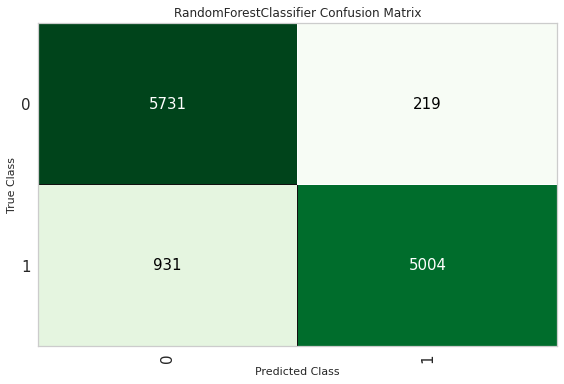

In [43]:
plot_model(estimator = rf, plot = 'confusion_matrix')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


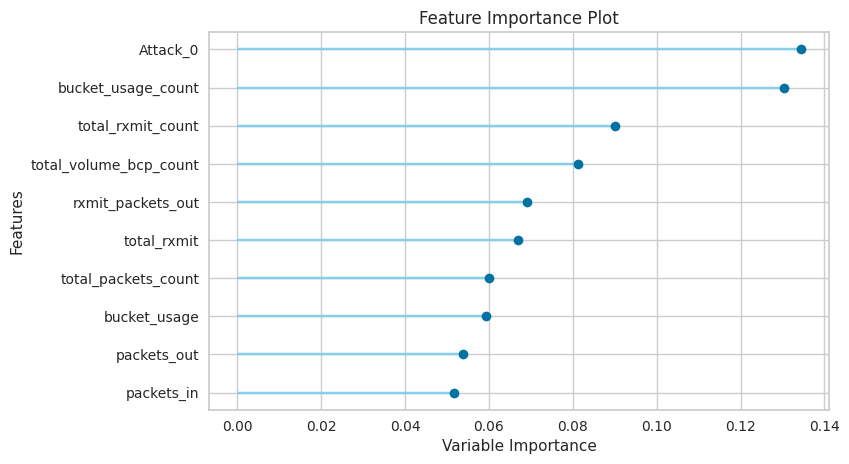

In [44]:
plot_model(estimator = rf, plot = 'feature')

In [49]:
pred = predict_model(rf, data=df_tes)

In [50]:
pred.head()

,msisdn,event_date,cgi,total_volume_bcp,hits_tether,rxmit_packets_in,rxmit_packets_out,packets_in,packets_out,bucket_usage,...,Telco,Update,VPN,Web,WebApps,eCommerce,non-established,unclassified,Label,Score
0,6281210077714,2020-12-01,510100148743021,3633776001,0,430,942,2348290,1665496,3516935,...,0,0,0,1,0,0,0,0,0,0.63
1,6281210077714,2020-12-01,510100148743022,7242484799,0,3148,3555,4649069,3960297,6907476,...,0,0,0,1,0,0,0,0,1,0.79
2,6281210077714,2020-12-03,510100148743021,3185885366,0,1895,1323,2509610,835718,3072001,...,0,0,0,1,0,0,0,0,1,1.00
3,6281210077714,2020-12-03,510100148743025,9893298731,0,4578,3600,7250319,3455702,10827474,...,0,0,0,1,0,0,0,0,1,1.00
4,6281210077714,2020-12-03,510100148743021,3185885366,0,1895,1323,2509610,835718,3072001,...,0,0,0,1,0,0,0,0,1,1.00


In [53]:
pred = round(pred['Score']).astype(int)
pred.to_csv('Pred_Overview_3.csv',index=False)
pred.head()

KeyError: 'Score'